#Going Deeper(CV) - 없다면 어떻게 될까? (ResNet Ablation Study)

이번 프로젝트는 애블레이션 연구(Ablation Study)입니다.

기존에 존재하는 ResNet 모델에서 모든 기능을 빼고 층만 쌓은 다음

실제 ResNet모델하고 성능 차이를 한번 확인해보겠습니다.

실제 논문만 보고 모델 구현은 처음이었기에 구글과 깃허브를 많이 참조하였습니다.

목차

- 라이브러리 임포트

- 개 VS 고양이 데이터셋 다운

- 데이터 정보 확인

- 데이터 전처리

- ResNet모델 생성

- ResNet모델들 정의

- 모델들 학습 및 결과 확인

- 마무리

##라이브러리 임포트

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras import layers
import urllib3
urllib3.disable_warnings()

---

##개 VS 고양이 데이터셋 다운

저희는 이번 프로젝트에서 dog vs cat이라는 아주 유명한 데이터셋을 사용할것입니다.

tensorflow_datasets안에 속해있으므로 다운로드 받아줍니다.

In [ ]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteO5OYAG/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


---

##데이터 정보 확인

###features 확인

In [ ]:
#정보확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


---

###label값 확인

In [ ]:
ds_info.features["label"].num_classes

2

In [ ]:
ds_info.features["label"].names

['cat', 'dog']

---

###데이터 시각화

다운로드한 데이터가 제대로 다운이 되었는지 시각화를 하여 확인해보겠습니다.

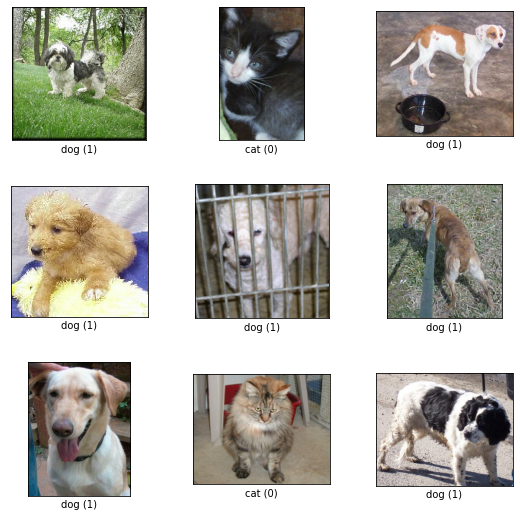

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

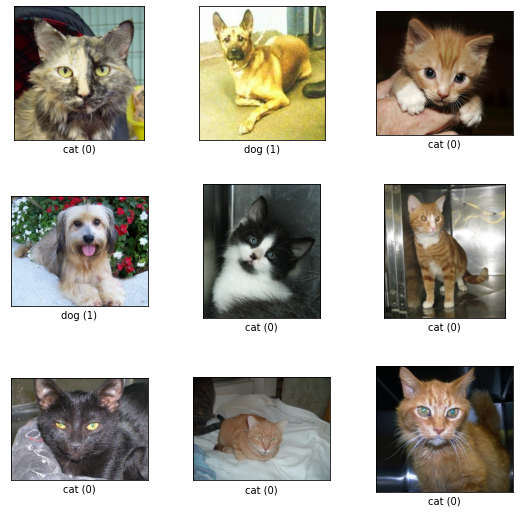

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

---

##데이터 전처리

###데이터 정규화

사진 데이터를 처리하는데 필수인 정규화를 해줍시다.

본 과정에서 데이터의 크기와 정규화 과정이 포함되어 있습니다.

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

---

###데이터 생성

학습에 필요한 train, test를 생성해줍니다.

In [ ]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size = 32)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = 32)

In [ ]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


---

##ResNet모델 생성
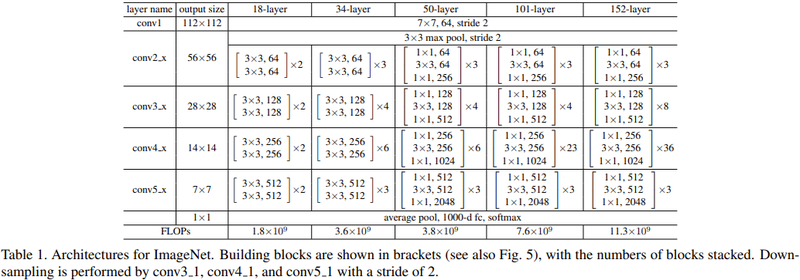

대충 이따구로 생겼습니다.

**conv 레이어가 총 5개가 들어가는데 1개의 conv레이어 안에는 conv2d, batdhnormal, acrivation이 포함**되어 있습니다.

###conv_block 생성

 1개의 conv레이어 안에는 conv2d, batdhnormal, acrivation이 포함되어 있습니다.

 저 조건을 만족하는 함수를 만들어 주겠습니다.

In [ ]:
def conv_block(input_layer, channel, kernel_size, strides=1, activation='relu'):
    
    x = keras.layers.Conv2D(filters = channel, kernel_size = kernel_size, kernel_initializer = 'he_normal',
        padding = 'same', strides = strides, use_bias = False)(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

---

###build_net_block 생성

위의 **구조를 보시면 1개의 conv 레이어는 총 2개 혹은 3개씩 짝을 이뤄 3, 4, 6, 3씩 반복되고 있습니다(ResNet34, 50기준)**

따라서 반복 조건을 만족시키는 함수도 만들어줍니다.

주의 : **이번 프로젝트의 Ablation Study을 목적은 ResNet 비교 실험이기 때문에** 

**기본 ResNet34, 50이외의 그냥 레이어만 쌓은 plain한 모델도 만들어 줍니다**.

즉, is_50, is_ResNet이라는 인자를 넣어 인자에 따라 원하는 모델을 생성할 수 있게 만들어줍니다.

In [ ]:
def build_net_block(input_layer, cnn_count = 3, channel = 64, block_num = 0, is_50 = True, is_ResNet = True):

    x = input_layer

    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

---

###build_net 생성

최종적으로 모델을 완성시켜주는 함수를 만들어줍니다.

In [ ]:
def build_net(input_shape = (32, 32, 3), cnn_count_list = [3, 4, 6, 3], channel_list = [64, 128, 256, 512],
                num_classes = 2, is_50 = True, is_ResNet = True, activation = 'softmax', name = 'ResNet_50'):
    
    assert len(cnn_count_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape = input_shape)
    
    x = conv_block(input_layer, 64, (7,7), strides = 2)
    x = keras.layers.MaxPool2D(pool_size = (2,2), strides = 2)(x)
    
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count = cnn_count, 
                            channel = channel, 
                            block_num = block_num, 
                            is_50 = is_50,
                            is_ResNet = is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation = activation, 
                        kernel_initializer = 'he_normal'
                        )(x)
    
    model = keras.Model(inputs = input_layer, outputs = x, name = name)
    
    return model

---

##ResNet 모델들 정의

###plain_34 정의

무작정 층만 34개 쌓은 모델의 파라미터를 확인해보겠습니다.

In [ ]:
plain_34 = build_net(
    input_shape = (224,224,3),
    is_50 = False,
    is_ResNet = False,
    num_classes = 1,
    activation = 'sigmoid',
    name = 'Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        368

---

###ResNet_34 정의

ResNet_34 모델을 만들어줍니다.

In [ ]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50 = False,
    is_ResNet = True,
    num_classes = 1,
    activation = 'sigmoid',
    name = 'ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 112, 112, 64  256        ['conv2d_33[0][0]']              
 ormalization)                  )                                                         

---

###plain_50 정의

무작정 층만 50개 쌓은 모델의 파라미터를 확인해보겠습니다.

In [ ]:
plain_50 = build_net(
    input_shape = (224,224,3),
    is_50 = True,
    is_ResNet = False,
    num_classes = 1,
    activation = 'sigmoid',
    name = 'Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_69 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_69 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_66 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_70 (Conv2D)          (None, 56, 56, 64)        409

---

###ResNet_50 정의

ResNet_50 모델을 만들어줍니다.

In [ ]:
resnet_50 = build_net(
    input_shape = (224,224,3),
    is_50 = True,
    is_ResNet = True,
    num_classes = 1,
    activation = 'sigmoid',
    name = 'ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 112, 112, 64  9408        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_118 (Batch  (None, 112, 112, 64  256        ['conv2d_118[0][0]']             
 Normalization)                 )                                                         

---

##모델들 학습 및 결과 확인

###EPOCHS, BATCH_SIZE 정의

EPOCHS, BATCH_SIZE를 사전에 미리 정의해둡니다.

In [ ]:
epochs = 10
batch_size = 32

----

###plain_34 모델 학습

plain_34 모델을 먼저 학습시킵니다.

**따로 모멘텀은 적용시키지 않고 밑에 코드 조건과 똑같이 학습**시켜주겠습니다.

In [ ]:
plain_34.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.SGD(
            learning_rate = 0.001), metrics = ['accuracy'])

history_plain_34 = plain_34.fit(
        ds_train,
        steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps = int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs = epochs,
        validation_data = ds_test,
        verbose = 1,
        use_multiprocessing = True)

Epoch 1/10
581/581 [==============================] - 101s 131ms/step - loss: 0.6880 - accuracy: 0.5458 - val_loss: 0.6969 - val_accuracy: 0.5185
Epoch 2/10
581/581 [==============================] - 71s 123ms/step - loss: 0.6878 - accuracy: 0.5403 - val_loss: 0.7112 - val_accuracy: 0.4764
Epoch 3/10
581/581 [==============================] - 71s 122ms/step - loss: 0.6925 - accuracy: 0.5137 - val_loss: 0.6884 - val_accuracy: 0.5446
Epoch 4/10
581/581 [==============================] - 70s 121ms/step - loss: 0.6876 - accuracy: 0.5374 - val_loss: 0.6926 - val_accuracy: 0.5583
Epoch 5/10
581/581 [==============================] - 70s 121ms/step - loss: 0.6827 - accuracy: 0.5577 - val_loss: 0.6937 - val_accuracy: 0.5249
Epoch 6/10
581/581 [==============================] - 70s 121ms/step - loss: 0.6867 - accuracy: 0.5409 - val_loss: 0.6982 - val_accuracy: 0.5224
Epoch 7/10
581/581 [==============================] - 72s 123ms/step - loss: 0.6907 - accuracy: 0.5248 - val_loss: 0.6899 - val_a

---

###ResNet_34 모델 학습

compile조건은 plain_34와 동일한 조건으로 학습을 진행합니다.

In [ ]:
resnet_34.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.SGD(
            learning_rate = 0.001), metrics = ['accuracy'])

history_resnet_34 = resnet_34.fit(
        ds_train,
        steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps = int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs = epochs,
        validation_data = ds_test,
        verbose = 1,
        use_multiprocessing = True)

Epoch 1/10
581/581 [==============================] - 87s 127ms/step - loss: 0.6744 - accuracy: 0.5837 - val_loss: 0.6559 - val_accuracy: 0.6123
Epoch 2/10
581/581 [==============================] - 73s 126ms/step - loss: 0.6408 - accuracy: 0.6376 - val_loss: 0.6320 - val_accuracy: 0.6517
Epoch 3/10
581/581 [==============================] - 75s 129ms/step - loss: 0.6156 - accuracy: 0.6615 - val_loss: 0.6230 - val_accuracy: 0.6550
Epoch 4/10
581/581 [==============================] - 78s 134ms/step - loss: 0.5998 - accuracy: 0.6756 - val_loss: 0.6010 - val_accuracy: 0.6723
Epoch 5/10
581/581 [==============================] - 75s 129ms/step - loss: 0.5769 - accuracy: 0.6947 - val_loss: 0.6006 - val_accuracy: 0.6741
Epoch 6/10
581/581 [==============================] - 73s 126ms/step - loss: 0.5529 - accuracy: 0.7171 - val_loss: 0.6011 - val_accuracy: 0.6816
Epoch 7/10
581/581 [==============================] - 73s 125ms/step - loss: 0.5275 - accuracy: 0.7364 - val_loss: 0.5887 - val_ac

---

###plain_34, ResNet_34 결과 시각화

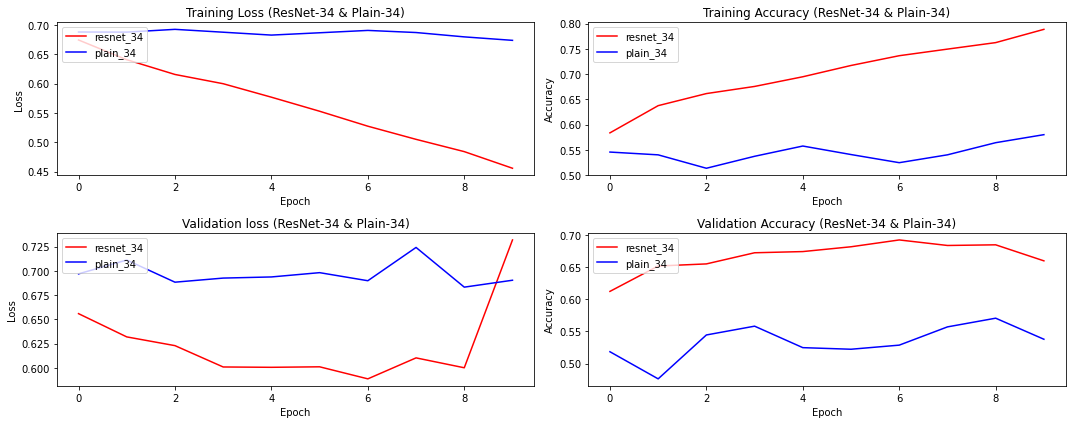

In [ ]:
plt.subplots(figsize = (15,6))

plt.subplot(2, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('Validation loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Validation Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

plt.show()

---

###plain_50 모델 학습

compile 조건은 기존의 학습모델과 똑같이 지정해줍니다.

In [ ]:
plain_50.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.SGD(
            learning_rate = 0.001), metrics = ['accuracy'])

history_plain_50 = plain_50.fit(
        ds_train,
        steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps = int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs = epochs,
        validation_data = ds_test,
        verbose = 1,
        use_multiprocessing = True)

Epoch 1/10
581/581 [==============================] - 113s 166ms/step - loss: 0.6954 - accuracy: 0.5108 - val_loss: 0.7546 - val_accuracy: 0.5123
Epoch 2/10
581/581 [==============================] - 95s 164ms/step - loss: 0.6908 - accuracy: 0.5302 - val_loss: 0.6937 - val_accuracy: 0.5589
Epoch 3/10
581/581 [==============================] - 96s 165ms/step - loss: 0.6916 - accuracy: 0.5252 - val_loss: 0.7356 - val_accuracy: 0.5319
Epoch 4/10
581/581 [==============================] - 98s 168ms/step - loss: 0.6918 - accuracy: 0.5243 - val_loss: 0.6918 - val_accuracy: 0.5266
Epoch 5/10
581/581 [==============================] - 100s 173ms/step - loss: 0.6918 - accuracy: 0.5267 - val_loss: 0.6995 - val_accuracy: 0.5297
Epoch 6/10
581/581 [==============================] - 95s 164ms/step - loss: 0.6921 - accuracy: 0.5203 - val_loss: 0.6925 - val_accuracy: 0.5397
Epoch 7/10
581/581 [==============================] - 95s 164ms/step - loss: 0.6927 - accuracy: 0.5249 - val_loss: 0.7108 - val_

---

###ResNet_50 모델 학습

compile 조건은 기존의 학습모델과 똑같이 지정해줍니다.

In [ ]:
resnet_50.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.SGD(
            learning_rate = 0.001), metrics = ['accuracy'])

history_resnet_50 = resnet_50.fit(
        ds_train,
        steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps = int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs = epochs,
        validation_data = ds_test,
        verbose = 1,
        use_multiprocessing = True)

Epoch 1/10
581/581 [==============================] - 82s 116ms/step - loss: 0.7069 - accuracy: 0.5149 - val_loss: 0.7172 - val_accuracy: 0.5183
Epoch 2/10
581/581 [==============================] - 67s 115ms/step - loss: 0.6993 - accuracy: 0.5337 - val_loss: 0.7126 - val_accuracy: 0.5390
Epoch 3/10
581/581 [==============================] - 67s 115ms/step - loss: 0.6928 - accuracy: 0.5484 - val_loss: 0.6906 - val_accuracy: 0.5641
Epoch 4/10
581/581 [==============================] - 67s 115ms/step - loss: 0.6841 - accuracy: 0.5622 - val_loss: 0.6890 - val_accuracy: 0.5504
Epoch 5/10
581/581 [==============================] - 67s 116ms/step - loss: 0.6776 - accuracy: 0.5780 - val_loss: 0.6813 - val_accuracy: 0.5924
Epoch 6/10
581/581 [==============================] - 68s 117ms/step - loss: 0.6694 - accuracy: 0.5889 - val_loss: 0.6967 - val_accuracy: 0.5790
Epoch 7/10
581/581 [==============================] - 67s 116ms/step - loss: 0.6705 - accuracy: 0.5835 - val_loss: 0.6667 - val_ac

---

###plain_50, ResNet_50 결과 시각화

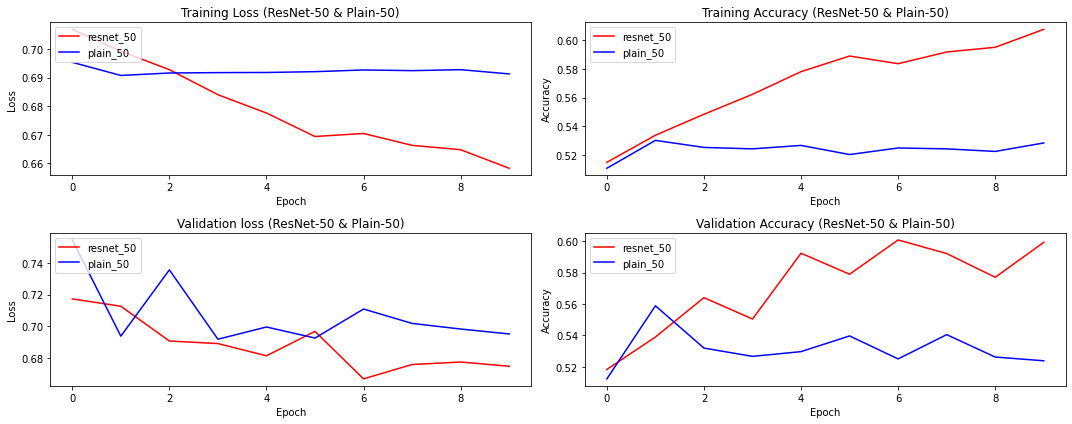

In [ ]:
plt.subplots(figsize = (15,6))

plt.subplot(2, 2, 1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('Validation loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Validation Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

plt.show()

---

###전체 결과 시각화

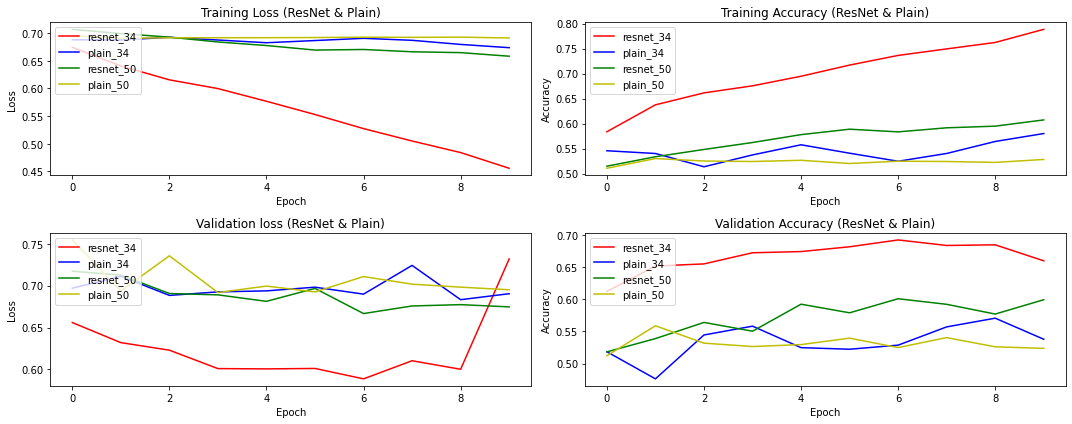

In [ ]:
plt.subplots(figsize = (15,6))

plt.subplot(2, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'y')
plt.title('Training Loss (ResNet & Plain)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'resnet_50', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.plot(history_resnet_50.history['accuracy'], 'g')
plt.plot(history_plain_50.history['accuracy'], 'y')
plt.title('Training Accuracy (ResNet & Plain)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'resnet_50', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.plot(history_resnet_50.history['val_loss'], 'g')
plt.plot(history_plain_50.history['val_loss'], 'y')
plt.title('Validation loss (ResNet & Plain)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'resnet_50', 'plain_50'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'y')
plt.title('Validation Accuracy (ResNet & Plain)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34', 'resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

plt.show()

---

##마무리

순위 먼저 확인해보자면 **ResNet34 -> ResNet50 -> plain34 -> plain50** 순 입니다.

어떻게 이런 결과가 나타났을까요?

그건 ResNet 기능중 하나인 **skip/shortcut connection때문**인건 같습니다.

실제 **plain 모델은 skip/shortcut connection 기능만 빼고 구현**한 것입니다.

**그 결과 ResNet50보다 낮은 레이어를 가지고 있는 plain34조차 정확도가 ResNet50보다 아래입니다**.

skip/shortcut connection은 다음과 같은 기능입니다.

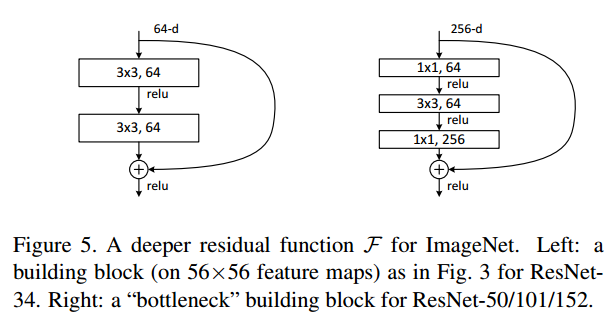

먼저 **skip connection은 "더 많은 layers를 사용하더라도 network를 우리가 원하는 대로 train될 수 있는가**?"

라는 의문으로 나오게 되었습니다.

하지만 **gradient 범위의 분포가 layer의 위치에 따라 상당한 차이를 보인다면 **

**일부 layer가 많은 역할을 하기 때문에 모든 layer를 잘 활용하지 못할 것입니다**.

이 문제를 **resnet에서는 short skip connections을 사용하는 residual architectures로 해결**합니다. 

몇 개의 layer를 건너 뛰어 연결해 non-linearities를 추가하는 skip connections는 gradient가 layers를 건너뛰어 연결될 수 있는 

**shortcuts를 만들어 parameters를 network에 deep하게 업데이트** 할 수 있습니다. 

**short skip connection을 통해 몇 개의 layers를 건너뛰면 gradient가 원활하게 흐릅니다**.

이러한 기능 덕분에 plain34가 ResNet50 보다 성능이 떨어지게 나타난것을 그래프를 통해서 확인할 수 있습니다.

실제로 논문에서도 실험을 했었습니다.

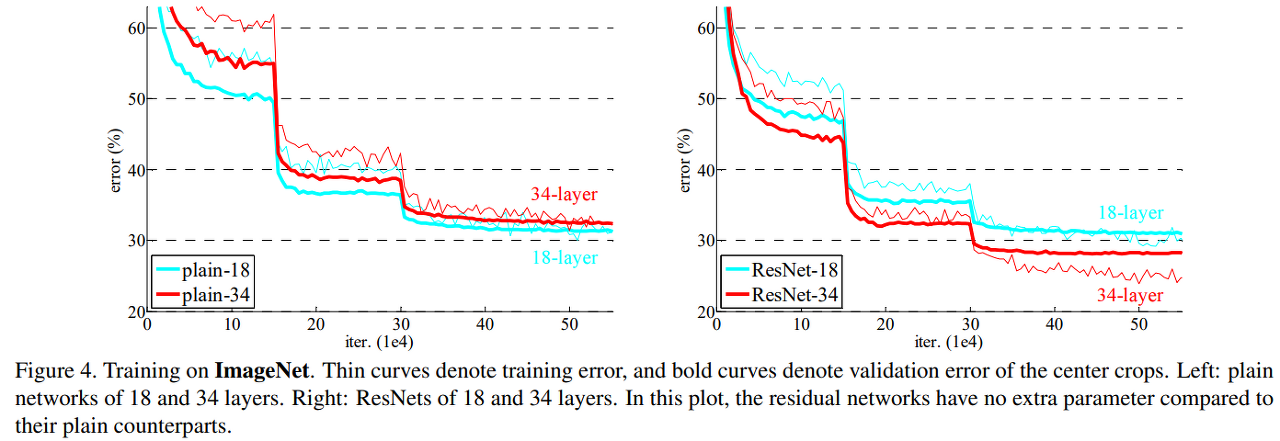

직접 **모델을 만들어본 결과 plain34, plain50 -> 모델이 점점 깊어질수록 **

**기울기 소실과 폭발 문제가 발생해서 정확도랑 loss값이 불안정**합니다.

하지만 **ResNet을 이용한 결과 모델이 깊어져도 skip/shortcut connection이라는** 

**기능을 사용하여 기울기 소실과 폭발 문제를 해결**하였습니다.

뭐든지 깊을수록 좋은건 아닌거 같습니다.

기회가 된다면 더 많이 학습을 시켜서 결과를 지켜보고 싶습니다.